#Klassifikation von Song-Texten

Die Aufgabe, oder auch das Ziel besteht darin, dass man anhand von Song-Texten vorhersagt von welchem Genre ein Lied ist. Bei der Umsetzung soll man unterschiedliche Methoden verwenden und diese untereinander auch vergleichen, dabei sollen die unterschiedlichen Methoden aus dem Machine Learning beziehungsweise aus dem Deep Learning Bereichen kommen. Die Umsetzung des Projektes ist in folgenden Schritten entwickelt worden:

1. Im ersten Schritt werden die Daten so weit vorbereitet Beziehungsweise bereinigt, sodass man mit ihnen die zuvor genannten Ziele auch erreichen kann. Die verwendeten Roh-Daten stammen von “https://www.kaggle.com/neisse/scrapped-lyrics-from-6-genres”.

2. Es wurde eine Baseline erstellt, um die Genauigkeit des neurnales Netzwerkes zu vergleichen. Dazu wurde Naive Bayes mit additiver Glättung verwendet.

3. Im dritten Schritt wurde ein Feed-Forward-Netzwerk erstellt.

4. Zum Schluss wurde noch ein Recurrent-Neural-Network trainiert.

Es werden die Genres Rock, Pop, Hip Hop, Samba, Sertanejo und Funk Carioca benutzt. 

In [17]:
import pandas as pd 
from sklearn.model_selection import train_test_split
from keras import models
from keras import layers
from sklearn.feature_extraction.text import CountVectorizer
from keras.preprocessing.text import Tokenizer
from keras.utils import to_categorical
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.feature_extraction.text import TfidfVectorizer 
from sklearn.metrics import confusion_matrix, precision_score, recall_score, f1_score, accuracy_score
from sklearn.preprocessing import LabelEncoder
from sklearn.naive_bayes import MultinomialNB
from keras.layers import Dropout

pd.options.mode.chained_assignment = None 

# load dataset 
pathLyrics = 'lyrics-data.csv'
pathArtists = 'artists-data.csv'


dataframe = pd.read_csv(pathLyrics)
dataframeArtists = pd.read_csv(pathArtists)

#Vorverarbeitung der Daten

Wie schon oben in der Kurzbeschreibung erwähnt, findet im ersten Schritt die Verarbeitung von Rohdaten statt, die so weit vorbereitet bzw. bereinigt werden müssen, sodass man diese für die verschiedene Modelle verwenden kann. Da es sich bei den Kaggle-Daten um große Datenmengen handelt, wurden die irrelevanten Datensätze entfernt. Einer der Bereinigungsschritte ist es, dass man sich nur auf englische Songtexte fokussiert, sodass die anderen Sprachen dabei entfernt werden. Die zwei importierten CSV-Dateien zu Genre und Texten werden zusammengeführt, sodass aus Tabelle Artist und der Tabelle Songs eine gemeinsame Tabelle erstellt wird. Diese Tabelle wird auf die nötigsten Informationen verkleinert um die zu verarbeitende Daten kleinzuhalten. Songtexte die irrelevante Sonderzeichen, Noten oder auch keine Texte beinhalten, werden auch entfernt. Des Weiteren ist einer der Schritte, dass alle Songtexte in kleingeschriebene Wörter umgewandelt werden, dadurch wird eine bessere Verarbeitung der Texte erreicht.

Ein Problem, welches bei der Datenvorbereitung aufgetreten ist, dass zwei identische Songtexte unterschiedliche Genres besitzen. Die Datensätze befinden sich in zwei getrennten CSV-Dateien. In der Datei "artists-data.csv" befinden sich neben weiteren Informationen der Artist und das Genre. Es sind ebenfalls in der Spalte "Genres" mehrere Genres angegeben, da ein Song auch mehrere Gernes wie zum Beispiel Pop und Hip Hop haben kann. In der CSV-Datei "lyrics-data.csv" befinden unter anderem der Songtext und das Idiom. Der Join der beiden CSV-Dateien wird über die Spalte "ALink" bei der CSV-Datei "lyrics-data.csv" und über die Spalte "Link" gemacht.

Die Zuordnung zwischen Artist und Song wird über die Spalte "ALink" bei der CSV-Datei "lyrics-data.csv" und über die Spalte "Link" bei der CVS-Datei "artists-data.csv" gemacht. Es kann nun vorkommen, dass ein Künstler, z.B. 10000 Maniacs, jeweils mit unterschiedlichen "Genre" aber gleichem "Link" im Datensatz vorkommt. Dies führt dazu, dass bei einem Join ein Song zweimal mit einem anderem Genre vorkommt. Zum Beheben dieses Problems wird nach dem Zusammenführen der CSV-Dateien über alle Zeilen iteriert und das Genre sowie der erste Eintrag in der Spalte "Genres" verglichen. Sollten diese nicht übereinstimmen, werden die entsprechenden Zeilen gelöscht.       



In [24]:
from sklearn.utils import shuffle

#Filtert alle Songtext, die nicht Englisch sind
dataframe = dataframe[dataframe['Idiom'] == 'ENGLISH']
#Lowercase alle Songtexte
dataframe['Lyric'] = dataframe['Lyric'].apply(lambda lyric: lyric.lower())

#Herausfiltern der Instrumentals 
patternDel = ["---", "instrumental","==="]
for patt in patternDel:
    filter = dataframe['Lyric'].str.contains(patt)
    dataframe = dataframe[~filter]

#Join der zwei CSV Dateien   
dataframe.rename(columns={'ALink':'Link','SName':'SName', 'SLink':'SLink','Lyric':'Lyric','Idiom':'Idiom'},inplace=True)
mergeData=pd.merge(dataframe, dataframeArtists, on='Link')

#Löschen aller Zeilen bei denen "Genre" und erstes Genre in "Genres" nicht übereinstimmen. Es wird durch die 
#Zeilen iteriert. Dabei wird der String in "Genres" gesplittet und in eine Liste geschrieben. Anschließend wird 
#verglichen. In listOfIndex stehen alle zu löschenden Indexe.
listOfIndex=[]
for ind in mergeData.index:
    if type(mergeData['Genres'][ind]) is str: 
        s_gerne = mergeData['Genre'][ind]
        #Splitten von "Genres"
        s_gernres = mergeData['Genres'][ind].split(";")
        if s_gerne !=  s_gernres[0]:
            listOfIndex.append(ind)
    else:
        listOfIndex.append(ind)
              
mergeData.drop(listOfIndex,inplace=True )

#Die Zeilen sind sortiert, deshalb muss noch gemischt werden.
rawData = shuffle(mergeData)


Durch die Entfernung aller nicht englischen Songtexten, dem Löschen alle Instrumentals und ähnliches sowie die Entfernung der mehrfach vorhandenen Songtexten stehen 61699 Datensätze zum Trainieren zur Verfügung.

#Baseline

Als Baseline zum Vergleich des neuronalen Netzwerkes wird Naive Bayes mit additiver Glättung verwendet. Die Datensätze wurden zu 80% Trainings- und Validierungsdaten sowie 20% für die Evaluierung aufgeteilt.

In [4]:
vectorizer = CountVectorizer()
X_cnt = vectorizer.fit_transform(rawData['Lyric'])

label_encoder = LabelEncoder()
y_clean = label_encoder.fit_transform(rawData['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0)

## Naive Bayes mit additiver Glättung trainieren
nb = MultinomialNB(alpha=1.0)
nb.fit(X_train, y_train)

## Vorhersagen berechnen
y_predicted = nb.predict(X_test)


## Konfusionsmatrix ausgeben
print("Kofusionsmatrix:\n", confusion_matrix(y_true=y_test, y_pred=y_predicted))

## Gütemaße ausgeben
print("Korrektklassifizierungsrate:\n", accuracy_score(y_true=y_test, y_pred=y_predicted))
print("Präzision (mikro):\n", precision_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("Ausbeute (mikro):\n", recall_score(y_true=y_test, y_pred=y_predicted, average='micro'))
print("F1 (mikro):\n", f1_score(y_true=y_test, y_pred=y_predicted, average='micro'))

Kofusionsmatrix:
 [[   0    0    0    0    0    0]
 [   0 1562  561  132    0    1]
 [   1  256 2408 1215    0    0]
 [   1  251 1355 4577    0    6]
 [   0    0    0    7    0    0]
 [   0    0    3    4    0    0]]
Korrektklassifizierungsrate:
 0.6926256077795786
Präzision (mikro):
 0.6926256077795786
Ausbeute (mikro):
 0.6926256077795786
F1 (mikro):
 0.6926256077795786


In diesem liefert der Klassifikator eine Genauigkeit von ca. 69%. 

#Feed Forward Network (FFN)
Im Folgenden wird ein neuronales Netzwerk für die Vorhersage der Genres genutzt. Zuerst werden zwei Funktionen definiert, die später mehrfach benötigt werden. Die Funktion "vectorize_sequences" ist dafür zuständig, den Songtext als binären Vektor darzustellen, der One-Hot-Encoded ist. Dies ist notwendig, da das FFN immer die gleiche Input-Länge benötigt. Es werden 100000 Dimensionen verwendet. Zusätzlich werden alle Sonderzeichen gefiltert.

Die zweite Funktion "vectorize_labels" sorgt dafür, dass die Genres bzw. die Labels One-Hot-Encoded werden.

In [5]:
def vectorize_sequences (dataframe, dimensions=10000):
    vect = CountVectorizer()
    X = vect.fit_transform(dataframe)
    tokenizer = Tokenizer(num_words=dimensions, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
    tokenizer.fit_on_texts(dataframe)
    sequences = tokenizer.texts_to_sequences(dataframe)
    one_hot_results = tokenizer.texts_to_matrix(dataframe, mode='binary')
    word_index = tokenizer.word_index
    print('Found %s unique tokens.' % len(word_index))

    return one_hot_results
    
def vectorize_labels(labels):
    le = preprocessing.LabelEncoder()
    encodedlabels = le.fit(labels)
    encodedlabels_transformed= le.transform(labels) 
    return to_categorical(encodedlabels_transformed)

Die Liedtext sowie die Genres werden in einen Vektor umgewandelt. Die Aufteilung in Trainings- und Evaluierungsdaten ist 80/20. 

In [6]:
X_cnt = vectorize_sequences(rawData['Lyric'])
y_clean = vectorize_labels(rawData['Genre'])

X_train, X_test, y_train, y_test = train_test_split(X_cnt, y_clean, test_size=0.2, random_state=0)

Found 101195 unique tokens.


Das Modell besteht aus insgesamt drei verschiedenen Schichten. Die Ausgabeschicht besteht insgesamt aus sechs Neuronen, für jede Kategorie eine. Da es sich um ein multi-class Klassifizierungsproblem handelt ist die Loss-Funktion "categorical_crossentropy". Die Aktivierungsfunktion ist "softmax". Die Ausgabewerte der Ausgabeschicht sind die Wahrscheinlichkeiten mit welchem die Genres klassifiziert werden.

In [7]:
model = models.Sequential()
model.add(layers.Dense(16, activation='relu', input_shape=(10000,)))
model.add(layers.Dense(16, activation='relu'))
model.add(layers.Dense(6, activation='softmax'))
model.compile(optimizer='sgd', loss='categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 16)                160016    
_________________________________________________________________
dense_2 (Dense)              (None, 16)                272       
_________________________________________________________________
dense_3 (Dense)              (None, 6)                 102       
Total params: 160,390
Trainable params: 160,390
Non-trainable params: 0
_________________________________________________________________


In [8]:
history = model.fit(X_train, y_train, epochs=50,batch_size=100, validation_split=0.2)

Train on 39487 samples, validate on 9872 samples
Epoch 1/50
39487/39487 [==============================] - 34s 864us/step - loss: 1.0822 - accuracy: 0.5527 - val_loss: 0.8038 - val_accuracy: 0.6550
Epoch 2/50
39487/39487 [==============================] - 10s 259us/step - loss: 0.7453 - accuracy: 0.6859 - val_loss: 0.7181 - val_accuracy: 0.6911
Epoch 3/50
39487/39487 [==============================] - 10s 258us/step - loss: 0.6926 - accuracy: 0.7054 - val_loss: 0.6899 - val_accuracy: 0.7051
Epoch 4/50
39487/39487 [==============================] - 10s 246us/step - loss: 0.6658 - accuracy: 0.7178 - val_loss: 0.6735 - val_accuracy: 0.7115
Epoch 5/50
39487/39487 [==============================] - 10s 249us/step - loss: 0.6463 - accuracy: 0.7273 - val_loss: 0.6632 - val_accuracy: 0.7197
Epoch 6/50
39487/39487 [==============================] - 11s 277us/step - loss: 0.6302 - accuracy: 0.7365 - val_loss: 0.6539 - val_accuracy: 0.7231
Epoch 7/50
39487/39487 [==============================] -

Die Grafik "Training and validation loss" zeigt, dass das Modell ab ca. 20 Epochen die Loss-Funktion nicht mehr dem Training-Loss annähert. Es hat keine Überanpassung stattgefunden. Bei einer Überanpassung bewegt sich das Training-Loss gegen 0, während die Validation-Loss immer größer wird. In Grafik "Training and validation accuracy" ist zusehen, dass die Validation-Accuracy ab der Epoche 25 sich nicht mehr signifikant verändert.

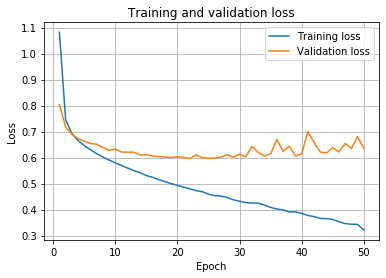

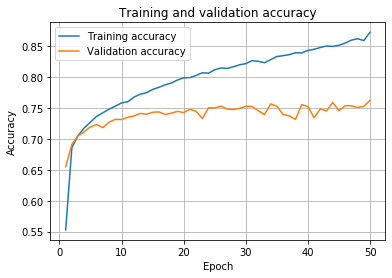

In [39]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']
train_acc = history_dict['accuracy']
val_acc = history_dict['val_accuracy']

epochs = range(1, len(train_loss) + 1)

plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()


In [10]:
#compute loss and accuracy on test data
score = model.evaluate( X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

12340/12340 [==============================] - 6s 468us/step
Test score: 0.6018515123347216
Test accuracy: 0.7732576727867126


Nachdem evaluieren des Vorhersagemodell, kann eine Genauigkeit von 77% festgestellt werden. Im Vergleich zu Naive Bayes, das eine Genauigkeit von 69% besitzt, ist dies eine Steigerung um 8%.

#Recurrent Neural Networks (RNN)
Im Folgenden wird noch zusätzlich ein RNN trainiert und mit dem FFN verglichen. Es wurde zusätzlich ein vortrainierter Embedding-Layer benutzt. Dazu wurde GloVe für die Word-Embeddings benutzt. Die txt-Datei kann unter dem Link "http://nlp.stanford.edu/data/glove.6B.zip" heruntergeladen werden. Die Datei "glove.6B.300d.txt" muss sich im gleichen Verzeichnis wie das jpyter Notbook befinden.

Es werden die 10000 meist benutzen Wörter betrachtet. Die "embedding dimensionality" ist auf 300 gesetzt.

In [29]:
import numpy as np
import nltk
from keras import models
from keras import layers
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from keras.layers import Embedding
from keras.layers import Flatten
from keras.preprocessing import sequence
from keras.initializers import Constant
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 



#k meisten Wörter werden betrachtet
num_words = 10000

# maximale Länge
max_len = 500

# embedding dimensionality
emb_dim = 300


#Vorverarbeitung der Daten
Die Daten werden nochmals vorverarbeitet. Alle Stoppwörter werden aus dem Songtexten gelöscht. Dazu wird 
Natural Language Toolkit (NLTK) benutzt. 

In [ ]:
#Download die Stoppwörter und Zeichen
nltk.download('stopwords')
nltk.download("punkt")

stop_words = stopwords.words('english')

#Es wird über alle Songtext iteriert. Mithilfe des Tokenizers wird der String in Wörter zerlegt, anschließend
#wird überprüft, ob das Word in stop_words ist. Wenn nicht wird es der Liste hinzugefügt und am Ende wieder zu
#einem String zusammen geklebt. 
for ind in rawData.index:
    word_tokens = word_tokenize(rawData['Lyric'][ind]) 
    filtered_sentence = [w for w in word_tokens if not w in stop_words] 
    rawData['Lyric'][ind] = ' '.join(filtered_sentence)
    
    
#Initialisieren des Tokenizers. 
tokenizer = Tokenizer(num_words=num_words, filters='!"#$%&()*+,-./:;<=>?@[\\]^_`{|}~\t\n')
tokenizer.fit_on_texts(rawData['Lyric'])
sequences = tokenizer.texts_to_sequences(rawData['Lyric'])
X_clean = sequence.pad_sequences(sequences,maxlen=max_len)

Y_clean = vectorize_labels(rawData['Genre'])


X_train, X_test, y_train, y_test = train_test_split(X_clean, Y_clean, test_size=0.1, random_state=0, shuffle=True)

In diesem Abschnitt wird der vortrainierten Embedding-Layer erstellt. Der dazu notwendige Code wurde in einem [Tutorial](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html) von Francois Chollet veröffentlicht. Der Codeabschnitt befinden sich auf [GitHub](https://blog.keras.io/using-pre-trained-word-embeddings-in-a-keras-model.html).

In [32]:
embeddings_index = {}
f = open('glove.6B.300d.txt',encoding="utf8")
for line in f:
    values = line.split()
    word = values[0]
    coefs = np.asarray(values[1:], dtype='float32')
    embeddings_index[word] = coefs
f.close()

print('Found %s word vectors.' % len(embeddings_index))


word_index= tokenizer.word_index
embedding_matrix = np.zeros((len(word_index) + 1, emb_dim))
for word, i in word_index.items():
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
num_words = min(num_words, len(word_index) + 1)
embedding_matrix = np.zeros((num_words, emb_dim))
for word, i in word_index.items():
    if i >= num_words:
        continue
    embedding_vector = embeddings_index.get(word)
    if embedding_vector is not None:
        # words not found in embedding index will be all-zeros.
        embedding_matrix[i] = embedding_vector
        
        
        

Found 400000 word vectors.


Als eine spezielle Variante des RNN wird ein Long short-term memory (LSTM) verwendet. LSTM eignen sich sehr gut für Textklassifizierungsprobleme. Wie auch FFN wird "categorical_crossentropy" als Loss-Funktion genutzt. Als Aktivierungsfunktion wird 'softmax' genutzt. 


Als Optimizer wird RMSprop benutzt. 

In [33]:
model = Sequential()
model.add((Embedding(num_words,emb_dim, 
                    embeddings_initializer=Constant(embedding_matrix),input_length=max_len,
                    trainable=False)))
model.add(LSTM(128, recurrent_dropout=0.8, dropout=0.8))

 model.add(LSTM(128))
model.add(Dense(6, activation='softmax'))
model.summary() 

model.compile(optimizer='rmsprop', loss='categorical_crossentropy', metrics=['acc'])
history = model.fit(X_train,y_train, epochs=4, batch_size=100, validation_split=0.2)



Model: "sequential_12"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding_11 (Embedding)     (None, 500, 300)          3000000   
_________________________________________________________________
lstm_11 (LSTM)               (None, 128)               219648    
_________________________________________________________________
dense_11 (Dense)             (None, 6)                 774       
Total params: 3,220,422
Trainable params: 220,422
Non-trainable params: 3,000,000
_________________________________________________________________
Train on 44423 samples, validate on 11106 samples
Epoch 1/24
44423/44423 [==============================] - 567s 13ms/step - loss: 1.0435 - acc: 0.4892 - val_loss: 0.9805 - val_acc: 0.5176
Epoch 2/24
44423/44423 [==============================] - 602s 14ms/step - loss: 0.9816 - acc: 0.5181 - val_loss: 0.9364 - val_acc: 0.5516
Epoch 3/24
44423/44423 [===============

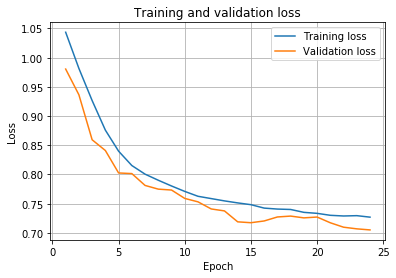

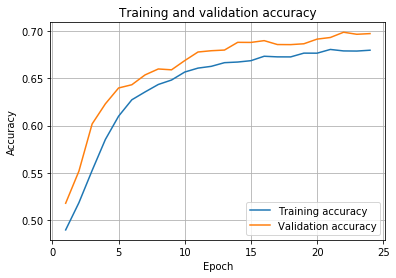

In [37]:
history_dict = history.history
train_loss = history_dict['loss']
val_loss = history_dict['val_loss']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation loss')
plt.plot(epochs, train_loss, label='Training loss')
plt.plot(epochs, val_loss, label='Validation loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid()
plt.show()


train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()

In [35]:
# compute loss and accuracy on test data
score = model.evaluate(X_test, y_test, verbose=1)
print("Test score:", score[0])
print("Test accuracy:", score[1])

6170/6170 [==============================] - 45s 7ms/step
Test score: 0.7151173321509091
Test accuracy: 0.685089111328125


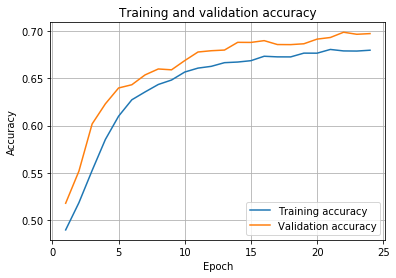

In [36]:
history_dict = history.history
train_acc = history_dict['acc']
val_acc = history_dict['val_acc']

epochs = range(1, len(train_loss) + 1)
plt.title('Training and validation accuracy')
plt.plot(epochs, train_acc, label='Training accuracy')
plt.plot(epochs, val_acc, label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.grid()
plt.show()